In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import networkx as nx
import seaborn as sns
import scipy.stats as stats
np.random.seed(8888)
from scipy.spatial.distance import cdist
import lap
from numpy import linalg as LA
from multiprocessing import cpu_count

from sklearn.metrics.pairwise import pairwise_kernels

import graspologic
from graspologic.inference import latent_distribution_test
from graspologic.embed import AdjacencySpectralEmbed, OmnibusEmbed
from graspologic.simulations import sbm, rdpg
from graspologic.utils import symmetrize
from graspologic.plot import heatmap, pairplot

import igraph as ig
from igraph import *

from scipy.sparse import csr_array

%matplotlib inline

In [258]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install mvlearn

In [2]:
def aseoos(Xhat, avec):
    n = Xhat.shape[0]
    
    if len(avec) != n:
        raise ValueError("Length of edge vector avec does not match size of latent position matrix Xhat.")

    ooshat = np.linalg.lstsq(Xhat.T @ Xhat, Xhat.T @ avec, rcond=None)[0]
    
    return ooshat

def array_split(data, m):
    rowIdx = np.arange(data.shape[0])
    # Split row indices into m groups
    split_indices = np.array_split(rowIdx, m)
    
    # Use the split indices to split the data array
    split_data = [data[x, :] for x in split_indices]
    
    return split_data

def check_repeated_rows(df):
    # Use duplicated() method to check for repeated rows
    duplicated_rows = df[df.duplicated()]
    if not duplicated_rows.empty:
        print("There are repeated rows.")
        print(duplicated_rows)
        print('numer is',duplicated_rows.shape )
    else:
        print("No repeated rows.")

def find_smallest_columns(row, num=1):# edit the k for softmatching
    return np.array(row.nsmallest(num).index)

def soft_matching_estimate(dists, oosB,vertex_shuffled,dim=2):
    dists_df = pd.DataFrame(dists)
    #ranked_df = dists_df.rank(axis=1, method='min')  # Using 'min' method for ranking
    dists_df.columns = [vertex_shuffled] #vertex_shuffled2
    dists_df.index = [vertex_shuffled]  
    #sorted_df = pd.DataFrame(np.sort(dists, axis=1), index=dists_df.index, columns=dists_df.columns)
    #check_repeated_rows(dists_df)
    smallest_columns = dists_df.apply(find_smallest_columns, axis=1)
    flattened_5cols = []
    for row in smallest_columns:
        flattened_5cols.append([item[0] for item in row])
    oosB_df = pd.DataFrame(oosB)
    oosB_df.index = [vertex_shuffled] 
    oosB_avg = np.zeros((len(vertex_shuffled), dim))
    for i in range(len(vertex_shuffled)):
        avg = np.array(oosB_df.loc[flattened_5cols[i]].mean())
        oosB_avg[i,:] = avg

    return oosB_avg

def generate_dirichlet_data(n, num_components=12):
    X = np.random.dirichlet([1] * num_components, n) 
    X = np.delete(X, [-2, -1], axis=1)  
    return X

In [3]:
n = 500
n_shuffle = int(n*0.2)
err = 0.011 # 0.01, 0.011, 0.012

kshuff = np.array([120]) # number shuffled in null
lshuff = np.array([20,30,40,50,60,80,90,100,110,120]) # number shuffled in alt
# parameters 
dim = 2 # embedding dim
m = 2 # number of graphs in test
nMC = 50 # 200

null_reg_a = np.zeros((nMC, len(kshuff)))
null_reg_a_avg = np.zeros((nMC, len(kshuff)))
alt_reg_a = np.zeros((nMC, len(lshuff)))
alt_reg_a_avg = np.zeros((nMC, len(lshuff)))

test_values1_1 = np.zeros((nMC, len(lshuff)))

# test_values1 = np.zeros((nMC, len(kshuff)))
# test_values1_1 = np.zeros((nMC, len(lshuff)))
# test_values2 = np.zeros((nMC, len(kshuff)))
# test_values2_2 = np.zeros((nMC, len(lshuff)))


In [4]:
for h in range(nMC):
    for j in range(len(kshuff)):
        X = generate_dirichlet_data(n=n, num_components=dim+2)
        adj1 = rdpg(X)
        adj1.astype(int)

        order_original = np.arange(0, n)
        vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False)
        unshuf = [item for item in order_original if item not in vertex_shuffled]
        reorder_vertex = np.concatenate((unshuf, vertex_shuffled))

        X2 = X[reorder_vertex,:]
        adj2 = rdpg(X2)
        adj2.astype(int)

        MA =  adj1[unshuf, :][:, unshuf]
        #MB = adj2[unshuf, :][:, unshuf]
        MB = adj2[0:(500-kshuff[j]), :][:, 0:(500-kshuff[j])]

        omni_embedder = OmnibusEmbed(n_components = dim)
        Zhats12 = omni_embedder.fit_transform([MA, MB])
        MA_xhat = Zhats12[0]
        MB_xhat = Zhats12[1]

        remaining_indices = np.setdiff1d(order_original, unshuf)
        MA_remain = adj1[remaining_indices,:][ :,unshuf] 
        
        oosA = np.zeros((kshuff[j], dim))
        for i in range(kshuff[j]):
            #shuffle_vector = RA[:,no_noshuff + i][:no_noshuff]
            #shuffle_vector = adj1[:,vertex_shuffled[i]][unshuf]
            #shuffle_vector = adj1[500-kshuff[j]+i, :(500-kshuff[j])]
            shuffle_vector = MA_remain[i,:]
            point_est = aseoos(MA_xhat, shuffle_vector)
            oosA[i, :] = point_est

        oosB = np.zeros((kshuff[j], dim))
        for i in range(kshuff[j]):
            #shuffle_vector = RB[:,no_noshuff + i][:no_noshuff]
            #shuffle_vector = adj2[:,vertex_shuffled[i]][unshuf]
            shuffle_vector = adj2[500-kshuff[j]+i, :(500-kshuff[j])]
            point_est = aseoos(MB_xhat, shuffle_vector)
            oosB[i, :] = point_est

        # calculate distance and match order
        dists = cdist(oosA, oosB, 'euclidean')
        cost, x1, y1 = lap.lapjv(dists)
        oosB_2 = oosB[x1]

        newA_xs = np.vstack((MA_xhat, oosA))
        newB_xs = np.vstack((MB_xhat, oosB_2))

        t_stat_1 = LA.norm(newA_xs - newB_xs, ord='fro') ** 2
        # dist_AB = cdist(newA_xs, newB_xs, 'euclidean')
        null_reg_a[h,j] = t_stat_1

        oosB_avg = soft_matching_estimate(dists,oosB,vertex_shuffled, dim = dim)
        newB_xs_avg = np.vstack((MB_xhat, oosB_avg))
        t_stat_avg1 = LA.norm(newA_xs - newB_xs_avg, ord='fro') ** 2
        null_reg_a_avg[h,j] = t_stat_avg1

        # # non-parametric test
        # test_value1 = latent_distribution_test(adj1, adj2,test="dcorr",metric='euclidean',n_components=2,
        #                                     workers=cpu_count() - 2, size_correction=True).stat
        # test_values1[h,j] = test_value1

        # test_value2 = latent_distribution_test(adj1, adj2,test="mgc",metric='euclidean',n_components=2,
        #                                     workers=cpu_count() - 2, size_correction=True).stat
        # test_values2[h,j] = test_value2


        s = sum(lshuff <= kshuff[j])
        for q in range(s):
            l = lshuff[q]
            vertex_shuffled2 = np.random.choice(order_original, l, replace=False)
            unshuf = [item for item in order_original if item not in vertex_shuffled2]
            reorder_vertex = np.concatenate((unshuf, vertex_shuffled2))

            X3 = X[reorder_vertex,:]+err
            adj3 = rdpg(X3)
            adj3.astype(int)

            MA =  adj1[unshuf, :][:, unshuf]
            #MC = adj3[unshuf, :][:, unshuf]
            MC = adj3[0:(500-l), 0:(500-l)]

            omni_embedder = OmnibusEmbed(n_components = dim)
            Zhats12 = omni_embedder.fit_transform([MA, MC])
            MA_xhat = Zhats12[0]
            MC_xhat = Zhats12[1]

            remaining_indices = np.setdiff1d(order_original, unshuf)
            MA_remain = adj1[remaining_indices,:][ :,unshuf] 

            oosA = np.zeros((l, dim))
            for i in range(l):
                #shuffle_vector = RA[:,no_noshuff + i][:no_noshuff]
                #shuffle_vector = adj1[:,vertex_shuffled[i]][unshuf]
                #shuffle_vector = adj1[500-l+i, :(500-l)]
                shuffle_vector = MA_remain[i,:]
                point_est = aseoos(MA_xhat, shuffle_vector)
                oosA[i, :] = point_est

            oosC = np.zeros((l, dim))
            for i in range(l):
                #shuffle_vector = RB[:,no_noshuff + i][:no_noshuff]
                #shuffle_vector = adj3[:,vertex_shuffled[i]][unshuf]
                shuffle_vector = adj3[500-l+i, :(500-l)]
                point_est = aseoos(MC_xhat, shuffle_vector)
                oosC[i, :] = point_est

            # calculate distance and match order
            dists2 = cdist(oosA, oosC, 'euclidean')
            cost, x1, y1 = lap.lapjv(dists2)
            oosC_2 = oosC[x1]

            newA_xs = np.vstack((MA_xhat, oosA))
            newC_xs = np.vstack((MC_xhat, oosC_2))

            t_stat_2 = LA.norm(newA_xs - newC_xs, ord='fro') ** 2
            alt_reg_a[h,q] = t_stat_2

            oosC_avg = soft_matching_estimate(dists2,oosC,vertex_shuffled2,dim = dim)
            newC_xs_avg = np.vstack((MC_xhat, oosC_avg))
            t_stat_avg2 = LA.norm(newA_xs - newC_xs_avg, ord='fro') ** 2
            alt_reg_a_avg[h,q] = t_stat_avg2
            
            # non-parametric test
            test_value1_1 = latent_distribution_test(adj1, adj3,test="hsic",metric='rbf',n_components=dim,
                                            workers=cpu_count() - 2, size_correction=True,
                                            n_bootstraps=200).pvalue 
                                            # np.dot(X, X.T), np.dot(X3, X3.T)
            test_values1_1[h,q] = test_value1_1

            
            # # non-parametric test
            # test_value1_1 = latent_distribution_test(adj1, adj3,test="dcorr",metric='euclidean',n_components=2,
            #                                 workers=cpu_count() - 2, size_correction=True).stat
            # test_values1_1[h,q] = test_value1_1
            # test_value2_2 = latent_distribution_test(adj1, adj3,test="mgc",metric='euclidean',n_components=2,
            #                                 workers=cpu_count() - 2, size_correction=True).stat
            # test_values2_2[h,q] = test_value2_2

In [69]:
#### testing on the soft matching

# def soft_matching_estimate(dists, oosB,vertex_shuffled,dim=2):
dists_df = pd.DataFrame(dists)
dists_df.columns = [vertex_shuffled] #vertex_shuffled2
dists_df.index = [vertex_shuffled]  
#sorted_df = pd.DataFrame(np.sort(dists, axis=1), index=dists_df.index, columns=dists_df.columns)
#check_repeated_rows(dists_df)
smallest_columns = dists_df.apply(find_smallest_columns, axis=1)
flattened_5cols = []
for row in smallest_columns:
    flattened_5cols.append([item[0] for item in row])
oosB_df = pd.DataFrame(oosB)
oosB_df.index = [vertex_shuffled] 
oosB_avg = np.zeros((len(vertex_shuffled), dim))
for i in range(len(vertex_shuffled)):
    avg = np.array(oosB_df.loc[flattened_5cols[i]].mean())
    oosB_avg[i,:] = avg

    # return oosB_avg
test = np.array(dists_df.loc[103])
print(test.min())
print(dists_df.loc[64,188])

In [8]:
###### don't run!!!!!
############# NON parametric tests ###########3
# test_values1,test_values2,test_values3 = [],[],[]
# test_values1_1,test_values2_2,test_values3_3 = np.zeros((len(kshuff), len(lshuff))),np.zeros((len(kshuff), len(lshuff))),np.zeros((len(kshuff), len(lshuff)))
test_values1 = np.zeros((nMC, len(kshuff)))
test_values2 = np.zeros((nMC, len(kshuff)))
test_values3 = np.zeros((nMC, len(kshuff)))
test_values1_1 = np.zeros((nMC, len(lshuff)))
test_values2_2 = np.zeros((nMC, len(lshuff)))
test_values3_3 = np.zeros((nMC, len(lshuff)))
for h in range(nMC):
    for j in range(len(kshuff)):
        k = kshuff[j]
        X = np.random.dirichlet((1,1,1,1),n) ### 
        X = np.delete(X, [2,3], 1)
        # X = np.random.dirichlet((1,1,1,1,1,1,1,1,1,1,1,1),n)
        # X = np.delete(X, [10,11], 1)
        adj1 = rdpg(X)
        adj1.astype(int)

        order_original = np.arange(0, n)
        vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False)
        unshuf = [item for item in order_original if item not in vertex_shuffled]
        reorder_vertex = np.concatenate((unshuf, vertex_shuffled))

        X2 = X[reorder_vertex,:]
        adj2 = rdpg(X2)
        adj2.astype(int)
        # # non-parametric test
        # test_value1 = latent_distribution_test(adj1,adj2,test="hsic",metric="rbf",n_components=2,
        #                                     workers=cpu_count() - 2, size_correction=True,
        #                                     n_bootstraps=200).pvalue
        #                                     # np.dot(X, X.T), np.dot(X2, X2.T)
        # test_values1[h,j] = test_value1

        # test_value2 = latent_distribution_test(adj1,adj2,test="mgc",metric='euclidean',n_components=2,
        #                                     workers=cpu_count() - 2, size_correction=True,
        #                                     n_bootstraps = 200).pvalue
        # test_values2[h,j] = test_value2
        # test_value3 = latent_distribution_test(adj1,adj2,test="dcorr",metric='euclidean',n_components=2,
        #                                     workers=cpu_count() - 2, size_correction=True,
        #                                     n_bootstraps=200).pvalue
        # test_values3[h,j] = test_value3
        s = sum(lshuff <= k)
        for q in range(s):
            l = lshuff[q]
            vertex_shuffled2 = np.random.choice(order_original, l, replace=False)
            unshuf = [item for item in order_original if item not in vertex_shuffled2]
            reorder_vertex = np.concatenate((unshuf, vertex_shuffled2))

            X3 = X[reorder_vertex,:]+err
            adj3 = rdpg(X3)
            adj3.astype(int)
            # non-parametric test
            test_value1_1 = latent_distribution_test(adj1, adj3,test="hsic",metric='rbf',n_components=dim,
                                            workers=cpu_count() - 2, size_correction=True,
                                            n_bootstraps=200).pvalue 
                                            # np.dot(X, X.T), np.dot(X3, X3.T)
            test_values1_1[h,q] = test_value1_1
            # #test_values1_1.append(test_value1_1)
            
            # test_value2_2 = latent_distribution_test(adj1,adj3,test="mgc",metric='euclidean',n_components=2,
            #                                 workers=cpu_count() - 2, size_correction=True,
            #                                 n_bootstraps=200).pvalue
            # test_values2_2[h,q] = test_value2_2
            # #test_values2_2.append(test_value2_2)

            # test_value3_3 = latent_distribution_test(adj1,adj3,test="dcorr",metric='euclidean',n_components=2,
            #                                 workers=cpu_count() - 2, size_correction=True,
            #                                 n_bootstraps=200).pvalue
            # test_values3_3[h,q]= test_value3_3
            # #test_values3_3.append(test_value3_3)


In [43]:
# unique_rows, indices = np.unique(MA_xhat, axis=0, return_index=True)
# print(len(unique_rows))
# print(len(MA_xhat))

In [5]:
# Calculate null_crit_reg for Omni-oos
null_crit_reg = []
for j in range(len(kshuff)):
    null_crit_reg.append(np.quantile(null_reg_a[:, j], 0.95))

Pow_reg = np.zeros((len(kshuff), len(lshuff)))

# Calculate power
for j in range(len(kshuff)):
    kk = kshuff[j]
    ll = np.sum(lshuff <= kk)
    for q in range(ll):
        Pow_reg[j, q] = np.sum(alt_reg_a[:, q] > null_crit_reg[j]) / nMC

df = pd.DataFrame(np.vstack((lshuff, Pow_reg)).T)
df.columns = ["lshuff",120]
df2 = pd.melt(df, id_vars="lshuff")
df2["variable"] = pd.Categorical(df2["variable"], categories=df2["variable"].unique(), ordered=True)
df2['SE'] = np.sqrt(df2['value']*(1-df2['value'])/nMC)   ####################################
# Calculate null_crit_reg for soft matching
null_crit_reg = []
for j in range(len(kshuff)):
    null_crit_reg.append(np.quantile(null_reg_a_avg[:, j], 0.95))

Pow_reg = np.zeros((len(kshuff), len(lshuff)))

# Calculate power
for j in range(len(kshuff)):
    kk = kshuff[j]
    ll = np.sum(lshuff <= kk)
    for q in range(ll):
        Pow_reg[j, q] = np.sum(alt_reg_a_avg[:, q] > null_crit_reg[j]) / nMC

df = pd.DataFrame(np.vstack((lshuff, Pow_reg)).T)
df.columns = ['lshuff',120]
#df.columns = ['lshuff',50,80,n_shuffle,120]
df2_avg = pd.melt(df, id_vars="lshuff")
df2_avg["variable"] = pd.Categorical(df2_avg["variable"], categories=df2_avg["variable"].unique(), ordered=True)
df2_avg['SE'] = np.sqrt(df2_avg['value']*(1-df2_avg['value'])/nMC)  ###############################
# Calculate test values for non-parametric test
# null_crit_test = []
# for j in range(len(kshuff)):
#     null_crit_test.append(np.quantile(test_values1[:, j], 0.95))

Pow_test = np.zeros((len(kshuff), len(lshuff)))

# Calculate power
for j in range(len(kshuff)):
    kk = kshuff[j]
    ll = np.sum(lshuff <= kk)
    for q in range(ll):
        #Pow_test[j, q] = np.sum(test_values1_1[:, q] > null_crit_test[j]) / nMC
        Pow_test[j, q] = np.sum(test_values1_1[:, q] <0.05) / nMC

dff = pd.DataFrame(np.vstack((lshuff, Pow_test)).T)
#dff.columns = ['lshuff','10','20','30','50','70', '90', '100', '120','130']
dff.columns = ['lshuff',120]
dff2 = pd.melt(dff, id_vars="lshuff")
dff2["variable"] = pd.Categorical(dff2["variable"], categories=dff2["variable"].unique(), ordered=True)
dff2['SE'] = np.sqrt(dff2['value']*(1-dff2['value'])/nMC)  ####################################

In [97]:
# for saving file, DO NOT RUN!!
################################
dfs = [df2, df2_avg, dff2]
for d in dfs:
    d.to_csv('rdpg_0.012_dim10_soft1.csv', mode='a')

In [155]:
# for open the saved file:
###########################
file_path = 'rdpg_0.01.csv'
df_full = pd.read_csv(file_path)
total_rows = len(df_full)
rows_per_df = total_rows // 3  

df2 = df_full.iloc[:10]
df2_avg = df_full.iloc[11:21]
dff2 = df_full.iloc[22:]
df2 = df2.drop(df2.columns[0], axis=1)
df2_avg = df2_avg.drop(df2_avg.columns[0], axis=1)
dff2 = dff2.drop(dff2.columns[0], axis=1)

In [156]:
##################################
df2 = df2.apply(pd.to_numeric, errors='coerce')
df2_avg = df2_avg.apply(pd.to_numeric, errors='coerce')
dff2 = dff2.apply(pd.to_numeric, errors='coerce')

In [157]:
#######################################
df2['SE'] = np.sqrt(df2['value']*(1-df2['value'])/np.sqrt(nMC))
df2_avg['SE'] = np.sqrt(df2_avg['value']*(1-df2_avg['value'])/np.sqrt(nMC))
dff2['SE'] = np.sqrt(dff2['value']*(1-dff2['value'])/np.sqrt(nMC))

In [94]:
# plt.plot(MA_xhat[:,0],MA_xhat[:,1],'o',color = "red")
# plt.plot(MB_xhat[:,0],MB_xhat[:,1],'+',color = 'blue')
# #plt.plot(oosA[:,0],oosA[:,1],'s',color = "orange")
# plt.plot(oosC_2[:,0],oosC_2[:,1],'v',color = "green")
# plt.plot(oosB_2[:,0],oosB_2[:,1],'v',color = "yellow")

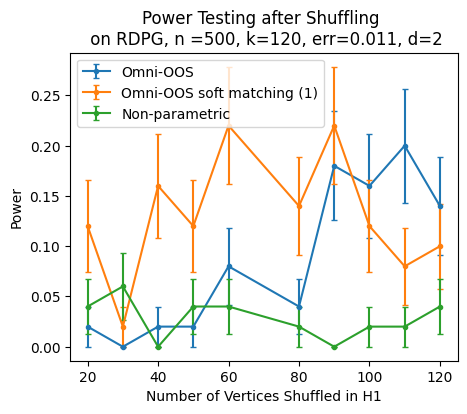

In [6]:
plt.figure(figsize=(5,4))
# plt.plot(df2[df2.variable == 120]['lshuff'], df2[df2.variable == 120]['value'], label ='Omni-OOS')
# plt.plot(df2_avg[df2_avg.variable == 120]['lshuff'], df2_avg[df2_avg.variable == 120]['value'], label ='Omni-OOS soft matching')
# plt.plot(dff2[dff2.variable == 120]['lshuff'], dff2[dff2.variable == 120]['value'], '-.', label ='Non-parametric')
plt.errorbar(df2[df2.variable == 120]['lshuff'], df2[df2.variable == 120]['value'],yerr = df2['SE'],
             fmt ='-o',label ='Omni-OOS',capsize=2, markersize=3)
plt.errorbar(df2_avg[df2_avg.variable == 120]['lshuff'], df2_avg[df2_avg.variable == 120]['value'],yerr = df2_avg['SE'],
             fmt ='-o',label ='Omni-OOS soft matching (1)',capsize=2, markersize=3)
plt.errorbar(dff2[dff2.variable == 120]['lshuff'], dff2[dff2.variable == 120]['value'],yerr = dff2['SE'],
             fmt ='-o',label ='Non-parametric',capsize=2, markersize=3)

plt.xlabel("Number of Vertices Shuffled in H1")
plt.ylabel("Power")
plt.legend()
plt.title('Power Testing after Shuffling \n on RDPG, n =' + str(n) + 
          ', k='+str(kshuff[j])+ ', err=' + str(err)+', d=2')  # + str(err)
plt.show()

In [182]:
# plt.plot(oosA[:,0],oosA[:,1],'o',color = "red")
# plt.plot(oosC_2[:,0],oosC_2[:,1],'+',color = 'blue')

In [355]:
vertex_shuffled = np.random.choice(order_original, kshuff[j], replace=False)
vertex_shuffled2 = np.random.choice(order_original, l, replace=False)

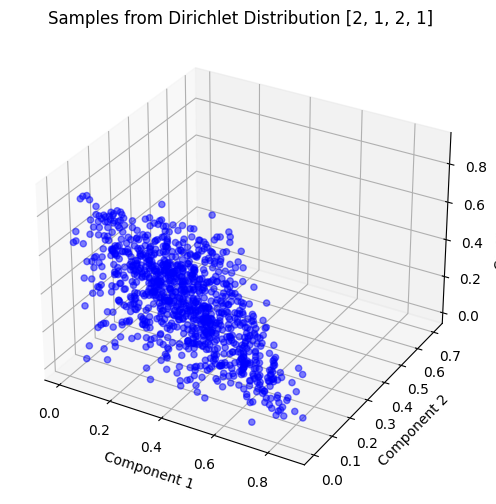

In [195]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import dirichlet

def plot_dirichlet(alpha, num_samples=1000):
    # Generate samples from the Dirichlet distribution
    samples = dirichlet.rvs(alpha, size=num_samples)

    # Create a ternary plot for visualization of Dirichlet samples
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Ternary plot coordinates (summing to 1)
    ax.scatter(samples[:, 0], samples[:, 1], samples[:, 2], c='b', marker='o', alpha=0.5)

    # Set labels and title
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    ax.set_title(f'Samples from Dirichlet Distribution {alpha}')

    plt.show()

# Example usage
plot_dirichlet([2,1 ,2,1])
